In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
import seaborn as sns
from geopy.distance import vincenty


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)


In [9]:
data_raw = pd.read_csv('taxi.csv')

In [3]:
data_raw.head(5)

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [82]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
offer_gk                   100000 non-null int64
weekday_key                100000 non-null int64
hour_key                   100000 non-null int64
driver_gk                  100000 non-null int64
order_gk                   100000 non-null int64
driver_latitude            100000 non-null float64
driver_longitude           100000 non-null float64
origin_order_latitude      100000 non-null float64
origin_order_longitude     100000 non-null float64
distance_km                100000 non-null float64
duration_min               100000 non-null float64
offer_class_group          100000 non-null object
ride_type_desc             100000 non-null object
driver_response            100000 non-null int64
offer_class_group_count    5 non-null float64
dtypes: float64(7), int64(6), object(2)
memory usage: 11.4+ MB


In [77]:
data_raw.groupby('driver_gk').count()

,offer_gk,weekday_key,hour_key,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,offer_class_group_count
driver_gk,,,,,,,,,,,,,,
14,212,212,212,212,212,212,212,212,212,212,212,212,212,0
22,94,94,94,94,94,94,94,94,94,94,94,94,94,0
42,202,202,202,202,202,202,202,202,202,202,202,202,202,0
51,261,261,261,261,261,261,261,261,261,261,261,261,261,0
75,222,222,222,222,222,222,222,222,222,222,222,222,222,0
80,140,140,140,140,140,140,140,140,140,140,140,140,140,0
81,141,141,141,141,141,141,141,141,141,141,141,141,141,0
98,56,56,56,56,56,56,56,56,56,56,56,56,56,0
156,157,157,157,157,157,157,157,157,157,157,157,157,157,0


No handles with labels found to put in legend.


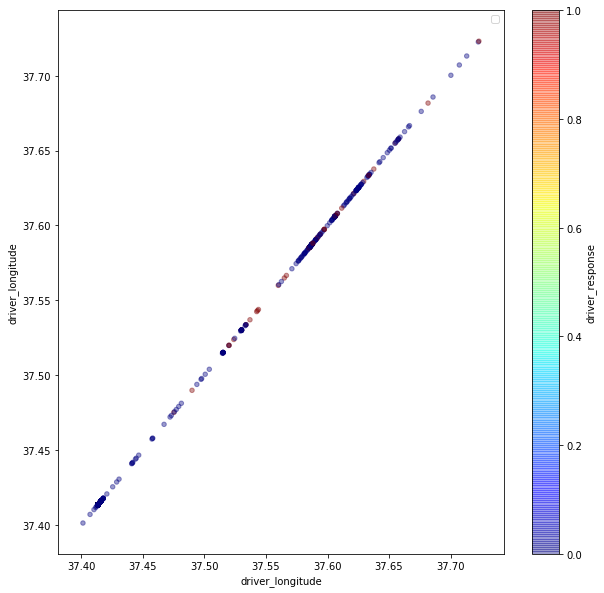

In [99]:
data_raw[data_raw.driver_gk == 1126].plot(kind="scatter", x="driver_longitude", y="driver_longitude", alpha=0.4,
    c="driver_response", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
_ = plt.legend()

No handles with labels found to put in legend.


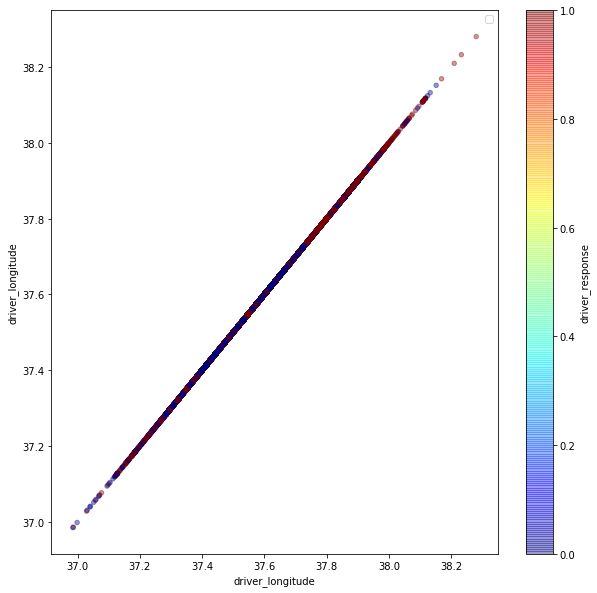

In [83]:
data_raw[data_raw.driver_longitude >= 10].plot(kind="scatter", x="driver_longitude", y="driver_longitude", alpha=0.4,
    c="driver_response", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
_ = plt.legend()

In [4]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [11]:
def get_counts(df_train, df_test, col, target_col):
    category_val_dict = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[col].value_counts()
    ).to_dict()
    df_train[col + '_counts'] = df_train[col].apply(category_val_dict.get)
    df_test[col + '_counts'] = df_test[col].apply(category_val_dict.get)
    return df_train, df_test

In [7]:
data_raw = pd.get_dummies(data_raw, prefix=['offer_class_group', 'ride_type_desc'], drop_first=False)

In [10]:
offer_class_group_dict = (
    data_raw[data_raw['driver_response'] == 1]['offer_class_group'].value_counts()
    /
    data_raw['offer_class_group'].value_counts()
).to_dict()

offer_class_group_dict

{'Delivery': 0.6775193798449612,
 'Economy': 0.4390400331023068,
 'Kids': 0.8401360544217688,
 'Premium': 0.7715736040609137,
 'Standard': 0.5234943326002368,
 'Test': 0.75,
 'VIP': 0.7733333333333333,
 'VIP+': 0.896551724137931,
 'XL': 0.7112068965517241}

In [12]:
data_raw['offer_class_group_count'] = data_raw['offer_class_group'].apply(offer_class_group_dict.get).head()

In [13]:
def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

In [14]:
def get_woe_stat(df_train, col, target):
    stat = df_train.groupby(col)[target].agg(
        [np.mean, np.size, np.count_nonzero], sort=False
    )
    stat.rename(columns={'count_nonzero': 'good', 'size': 'obs', 'mean': 'event_rate'}, inplace=True)
    stat['all_good'] = stat['good'].sum()
    stat['p_good'] = stat['good'] / stat['all_good']
    stat['bad'] = stat['obs'] - stat['good']
    stat['all_bad'] = stat['bad'].sum()
    stat['p_bad'] = stat['bad'] / stat['all_bad']
    stat['WOE']=np.log(stat['p_good'] / stat['p_bad'])
    stat['IV'] = ((stat['p_good'] - stat['p_bad']) * stat['WOE']).sum()
    stat['variable'] = col
    stat['category'] = stat.index
    stat.reset_index(inplace=True)
    stat.drop(labels=col, inplace=True, axis=1)
    return stat

In [133]:
get_woe_stat(data_raw,'offer_class_group', 'driver_response')

,event_rate,obs,good,all_good,p_good,bad,all_bad,p_bad,WOE,IV,variable,category
0,0.677519,1290,874,49248,0.017747,416,50752,0.008197,0.772477,0.083468,offer_class_group,Delivery
1,0.439040,48335,21221,49248,0.430901,27114,50752,0.534245,-0.214977,0.083468,offer_class_group,Economy
2,0.840136,588,494,49248,0.010031,94,50752,0.001852,1.689323,0.083468,offer_class_group,Kids
3,0.771574,1773,1368,49248,0.027778,405,50752,0.007980,1.247300,0.083468,offer_class_group,Premium
4,0.523494,47288,24755,49248,0.502660,22533,50752,0.443983,0.124129,0.083468,offer_class_group,Standard
5,0.750000,8,6,49248,0.000122,2,50752,0.000039,1.128695,0.083468,offer_class_group,Test
6,0.773333,225,174,49248,0.003533,51,50752,0.001005,1.257312,0.083468,offer_class_group,VIP
7,0.896552,29,26,49248,0.000528,3,50752,0.000059,2.189567,0.083468,offer_class_group,VIP+
8,0.711207,464,330,49248,0.006701,134,50752,0.002640,0.931335,0.083468,offer_class_group,XL


In [15]:
# create categories based on the part of the day
def process_hour(hour):
    if 6 <= hour < 12:
        return 0
    elif 12 <= hour < 18:
        return 1
    elif 18 <= hour < 24:
        return 2
    elif 0 <= hour < 6:
        return 3

In [16]:
# create "is weekend?" feature
def process_day(day):
    if day <= 4:
        return 0
    else:
        return 1

In [17]:
# get vincenty distance between two points
def compute_dist_in_km(coords1, coords2):
    return vincenty(coords1, coords2).kilometers

In [18]:
# calculate ride cost based on the plan
def compute_taxi_cost(row):
    if row.offer_class_group == "Economy":
        return 97 + 7 * row.distance_km + 7 * row.duration_min
    elif row.offer_class_group == "Standard":
        return 150 + 11 * row.distance_km + 13 * row.duration_min
    elif row.offer_class_group == "Premium":
        return 299 + 15 * row.distance_km + 20 * row.duration_min
    elif row.offer_class_group == "Kids":
        return 99 + 22 * row.duration_min
    elif row.offer_class_group == "VIP":
        return 699 + 55 * row.distance_km + 25 * row.duration_min
    elif row.offer_class_group == "XL":
        return 299 + 15 * row.distance_km + 25 * row.duration_min
    else:
        return -1

In [21]:
airports_coordinates = [
    ("Domodedovo", (55.415832, 37.896903), 3), # Domodedovo
    ("Sheremetyevo", (55.972323, 37.412804), 3), # Sheremetyevo
    ("Vnukovo", (55.598791, 37.269157), 3), # Vnukovo
    ("Zhukovskiy", (55.561805, 38.118139), 3), # Zhukovskiy
    ("Moscow_center", (55.753742, 37.621852), 5), # center
]

# calculate distance from driver to airport and from origin to airport
def compute_airport_driver_dist(data):
    for airport, (air_latitude, air_longitude), radius in airports_coordinates:
        print(airport)

        dist_column_name = 'driver_dist_to_{}'.format(airport)
        radius_column_name = 'driver_near_to_{}'.format(airport)
        data[dist_column_name] = data.apply(
            lambda row: compute_dist_in_km(
                (row['driver_latitude'], row['driver_longitude'], (air_latitude, air_longitude))
            ),
            axis=1
        )
        data[radius_column_name] = data[dist_column_name].apply(lambda x: 1 if x <= radius else 0)
        # print(radius, len(dummies_df[dummies_df[radius_column_name] == 1]))


        dist_column_name = 'origin_order_dist_to_{}'.format(airport)
        radius_column_name = 'origin_order_near_to_{}'.format(airport)
        data[dist_column_name] = data.apply(
            lambda row: compute_dist_in_km(
                (row['origin_order_latitude'], row['origin_order_longitude']), (air_latitude, air_longitude)
            ),
            axis=1
        )
        data[radius_column_name] = data[dist_column_name].apply(lambda x: 1 if x <= radius else 0)
        # print(radius, len(dummies_df[dummies_df[radius_column_name] == 1]))
    return data

In [22]:
def build_new_columns(data):
    origin_coordindates = data[
        ['origin_order_latitude', 'origin_order_longitude']
    ].apply(lambda x: str(np.round(x[0], 2)) + ' ' + str(np.round(x[1], 2)), axis=1)
    driver_coordinates = data[
        ['driver_latitude', 'driver_longitude']
    ].apply(lambda x: str(np.round(x[0], 2)) + ' ' + str(np.round(x[1], 2)), axis=1)
    data['origin_coordinates'] = origin_coordindates
    data['driver_coordinates'] = driver_coordinates
    
    data = get_one_hot(
        data,
        ['offer_class_group', 'ride_type_desc', 'weekday_key', 'hour_key']
    )
    data['day_part'] = data.apply(lambda row: process_hour(row.hour_key), axis=1)
    data['week_part'] = data.apply(lambda row: process_day(row.hour_key), axis=1)

    data['driver_response_by_day_and_part'] = data[
        ['weekday_key', 'hour_key']
    ].apply(lambda x: str(x[0]) + '_' + str(x[1]), axis=1)

    data['driver_to_offer_dist'] = data.apply(lambda row: compute_dist_in_km(
            (row.driver_latitude, row.driver_longitude),
            (row.origin_order_latitude, row.origin_order_longitude)
        ), axis=1)

    data['taxi_cost'] = data.apply(lambda row: compute_taxi_cost(row), axis=1)
    
    data = data.drop(
        labels=['offer_class_group', 'ride_type_desc', 'weekday_key', 'hour_key'],
        axis=1
    )
    data['duration_min_rounded'] = data['duration_min'].apply(lambda x: np.round(x, 0))
    data['is_address_submitted'] = data['duration_min'].apply(lambda x: x != -1)
    order_dict = data.order_gk.value_counts().to_dict()
    data['amount_of_offers'] = data['order_gk'].apply(order_dict.get)
    data['traffic'] = data[['distance_km', 'duration_min']].apply(
        lambda x: x[0] * 1. / x[1] if (x[1] != -1) and (x[0] != -1) else -1,
        axis=1
    )
    
    return data

In [23]:
y = data_raw['driver_response'].copy()
# data_raw.drop(['driver_response'], inplace=True, axis=1)

In [24]:
data_train, data_test, y_train, y_test = train_test_split(data_raw, y, test_size=0.3, random_state=42)

In [25]:
data_train = build_new_columns(data_train)
data_test = build_new_columns(data_test)

/Users/k.gusev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/k.gusev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/k.gusev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and

In [57]:
# data_train.origin_order_longitude.apply(lambda x: np.round(x, 3)).value_counts()
# data_train.origin_order_latitude.apply(lambda x: np.round(x, 3)).value_counts()

In [26]:
# build counts
columns_to_get_counts = [
    'driver_gk',
    'origin_coordinates',
    'driver_coordinates',
    'driver_response_by_day_and_part',
    'duration_min_rounded',
]
    
for col_get_prob in columns_to_get_counts:
    data_train, data_test = get_woe_v1(data_train, data_test, col_get_prob, 'driver_response')

In [27]:
train_columns = [
    col for col in data_train.columns.tolist()
    if col not in set(
        [
            'offer_gk',
            'order_gk',
            'driver_response',
            'driver_gk',
            'origin_coordinates',
            'driver_coordinates',
            'driver_response_by_day_and_part',
#             'driver_response_by_day_and_part_counts',
            'duration_min_rounded',
        ]
    )
]
x_train = data_train[train_columns]
y_train = data_train['driver_response']
x_test = data_test[train_columns]
y_test = data_test['driver_response']

In [44]:
x_train = x_train.astype(np.float32)
x_train = x_train.transform(lambda x: x.fillna(0))

x_test = x_test.astype(np.float32)
x_test = x_test.transform(lambda x: x.fillna(0))

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


clf = RandomForestClassifier(n_jobs=12,
                            n_estimators = 100,
                            max_features = 5,
                            max_depth = 5,
                            min_samples_split = 5,
                            min_samples_leaf = 9,   
#                            class_weight = {0:1,1:1000}
                            ).fit(x_train, y_train)



xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1).fit(x_train, y_train)

roc_auc_train = np.round(roc_auc_score(y_train, xgb.predict_proba(x_train)[:, 1]), 2)
roc_auc_test = np.round(roc_auc_score(y_test, xgb.predict_proba(x_test)[:, 1]), 2)

print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

roc_auc_train_rf = np.round(roc_auc_score(y_train, clf.predict_proba(x_train)[:, 1]), 2)
roc_auc_test_rf = np.round(roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1]), 2)

print("Train_rf: ", roc_auc_train_rf)
print("Test_rf: ", roc_auc_test_rf)

Train:  0.93
Test:  0.91
Train_rf:  0.89
Test_rf:  0.88


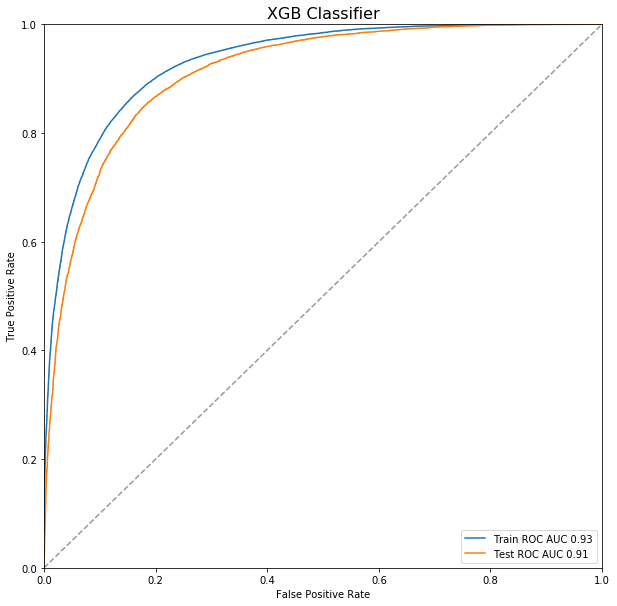

In [136]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

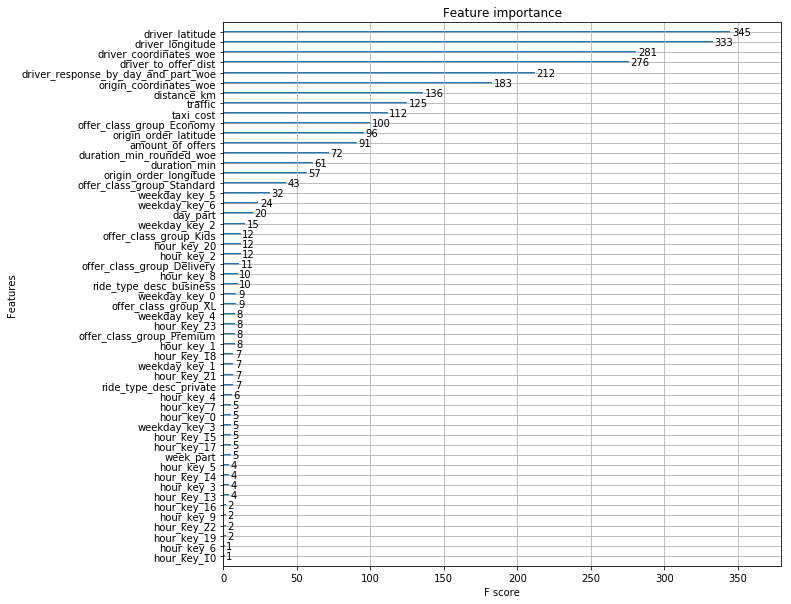

In [72]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')

# Прямой отбор переменных

In [55]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# custom_feature_names=feature_names
model = RandomForestClassifier(n_jobs=-1)
sfs_forward = SFS(model, 
           k_features=63, 
           forward=True, 
           floating=True, 
           verbose=1,
           scoring='roc_auc',
           cv=skf,
           n_jobs=-1)

sfs_forward = sfs_forward.fit(x_train.values, y_train.values,custom_feature_names=x_train.columns)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   10.2s finished
Features: 1/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
Features: 2/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.0s finished
Features: 3/63[Parallel(n_jobs=-1)]: Using bac

Features: 13/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    2.7s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    2.5s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.9s finished
Features: 13/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_job

[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    3.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    3.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    4.4s finished
Features: 17/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    3.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    5.0s finished
Features: 18/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurr

Features: 27/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   11.0s finished
Features: 28/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   10.9s finished
Features: 28/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent

[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   13.7s finished
Features: 34/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   14.9s finished
Features: 34/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   13.9s finished
[Parallel(n

[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:   25.4s finished
Features: 39/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   26.0s finished
Features: 40/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   28.1s finished
Features: 41/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concur

[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    8.7s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:   33.3s finished
Features: 48/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    8.1s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:   31.5s finished
Features: 49/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  14 | elapsed:    8.6s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   10.7s finished
[P

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   42.2s finished
Features: 60/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   42.6s finished
Features: 61/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   45.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      |

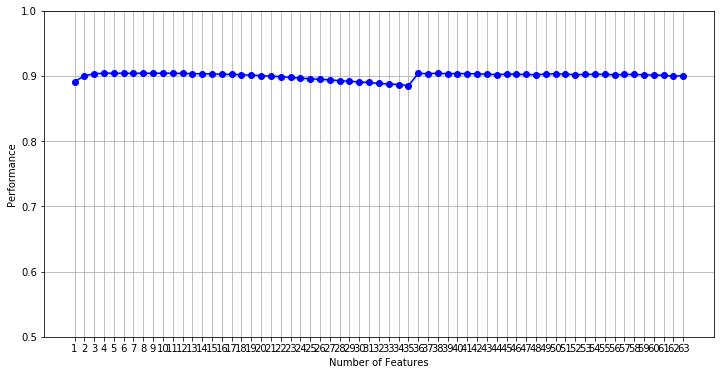

In [56]:
fig1 = plot_sfs(sfs_forward.get_metric_dict(), kind='std_dev')

plt.ylim([0.5, 1])
# plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
fig1.set_size_inches(12, 6)
plt.show()

In [57]:
sfs_forward.get_metric_dict()

{1: {'feature_idx': (58,),
  'cv_scores': array([0.89257428, 0.89110741, 0.88921435, 0.89242368]),
  'avg_score': 0.8913299278011804,
  'feature_names': ('driver_gk_woe',),
  'ci_bound': 0.0021610405636725964,
  'std_dev': 0.0013481383249720554,
  'std_err': 0.0007783480248274673},
 2: {'feature_idx': (11, 58),
  'cv_scores': array([0.90099915, 0.89878346, 0.89851191, 0.90185094]),
  'avg_score': 0.9000363643971176,
  'feature_names': ('offer_class_group_Standard', 'driver_gk_woe'),
  'ci_bound': 0.0022829694343377152,
  'std_dev': 0.0014242021371130252,
  'std_err': 0.0008222634872426454},
 3: {'feature_idx': (11, 56, 58),
  'cv_scores': array([0.90511017, 0.90240711, 0.90166622, 0.90434633]),
  'avg_score': 0.9033824578349479,
  'feature_names': ('offer_class_group_Standard',
   'amount_of_offers',
   'driver_gk_woe'),
  'ci_bound': 0.0022399897233496826,
  'std_dev': 0.0013973897780332311,
  'std_err': 0.0008067833645103175},
 4: {'feature_idx': (9, 11, 56, 58),
  'cv_scores': array

Проверка

In [96]:
x_train_new = x_train[['driver_latitude', 'driver_longitude']]
x_test_new = x_test[['driver_latitude', 'driver_longitude']]

In [68]:
x_test.columns

Index(['driver_latitude', 'driver_longitude', 'origin_order_latitude',
       'origin_order_longitude', 'distance_km', 'duration_min',
       'offer_class_group_count', 'offer_class_group_Delivery',
       'offer_class_group_Economy', 'offer_class_group_Kids',
       'offer_class_group_Premium', 'offer_class_group_Standard',
       'offer_class_group_Test', 'offer_class_group_VIP',
       'offer_class_group_VIP+', 'offer_class_group_XL', 'ride_type_desc_SMB',
       'ride_type_desc_affiliate', 'ride_type_desc_business',
       'ride_type_desc_private', 'weekday_key_0', 'weekday_key_1',
       'weekday_key_2', 'weekday_key_3', 'weekday_key_4', 'weekday_key_5',
       'weekday_key_6', 'hour_key_0', 'hour_key_1', 'hour_key_2', 'hour_key_3',
       'hour_key_4', 'hour_key_5', 'hour_key_6', 'hour_key_7', 'hour_key_8',
       'hour_key_9', 'hour_key_10', 'hour_key_11', 'hour_key_12',
       'hour_key_13', 'hour_key_14', 'hour_key_15', 'hour_key_16',
       'hour_key_17', 'hour_key_18', 'hour

In [97]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1).fit(x_train_new, y_train)

roc_auc_train = np.round(roc_auc_score(y_train, xgb.predict_proba(x_train_new)[:, 1]), 2)
roc_auc_test = np.round(roc_auc_score(y_test, xgb.predict_proba(x_test_new)[:, 1]), 2)

print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.82
Test:  0.82


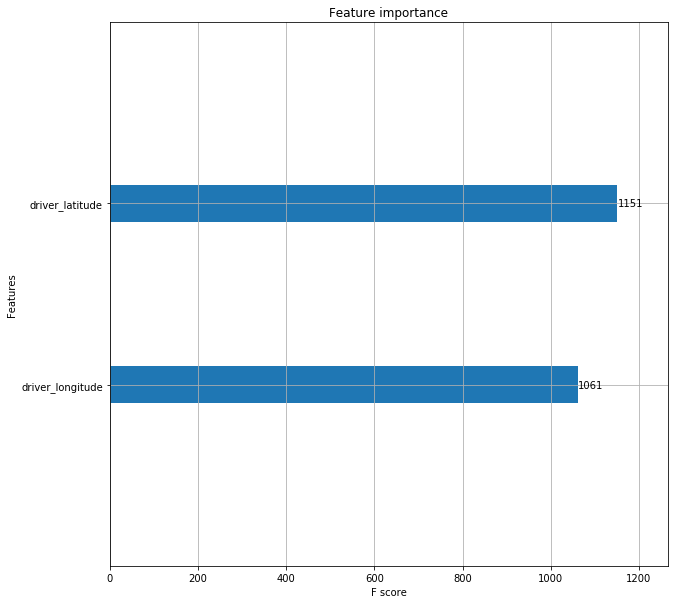

In [98]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')